# Word2Vec RecSys - Project Group 33

In this part of the project, we would like to have a look at how we can use the underlying algortihm of the Word2Vec NLP model for training a recommendation system on our data.

## 1 | Libaries & Data

Import all libraries and the data.

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
import pandas as pd
from gensim.models import Word2Vec
import umap
import seaborn
import matplotlib.pyplot as plt
import colorcet as cc
import csv 

In [6]:
train_sessions = pd.read_csv("~/shared/data/project/training/train_sessions.csv")
item_features = pd.read_csv("~/shared/data/project/training/item_features.csv")
train_purchases = pd.read_csv("~/shared/data/project/training/train_purchases.csv")

test_sessions = pd.read_csv("~/shared/data/project/test/test_sessions.csv")

## 2 | Data Exploration

We first want to check out the data we are dealing with.

In [7]:
train_sessions.shape

(4743820, 3)

In [8]:
train_sessions.head()

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211


In [9]:
item_features.head()

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75


In [10]:
train_purchases.head()

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114


In [7]:
test_sessions.head()

,session_id,item_id,date
0,126,9655,2020-12-18 21:25:00.373
1,126,9655,2020-12-18 21:19:48.093
2,3234,13214,2020-09-20 20:10:42.039
3,3234,13214,2020-09-20 20:11:53.966
4,3234,3173,2020-09-20 20:06:13.217


## 3 | Data Preprocessing

We need to perform various preprocessing steps before we can make use the dataset. The result we want to achieve are vectors of each session:

`session_1 = [100, 400, ... , 500]`

This vector represents all items viewed and purchased within `session_1`.

#### 3.1. Combine Data

In this step we will combine the train_session data with the train_purchase data. We will give more relevancy to the actual purchased products by combining the combined dataset once more with the original train_purchase data. This makes sense, since the Word2Vec algortihm is influenced by how often a certain "word" or "product" occurs in the data.

In [8]:
# combine the session and purchase data
combined_sessions = pd.concat([train_sessions, train_purchases])

# double weight on purchases
combined_sessions = pd.concat([combined_sessions, train_purchases])

# sort the data by session_id and by date
combined_sessions = combined_sessions.sort_values(by=['session_id', 'date']).reset_index(drop=True)

combined_sessions.head(5)

,session_id,item_id,date
0,3,9655,2020-12-18 21:19:48.093
1,3,9655,2020-12-18 21:25:00.373
2,3,15085,2020-12-18 21:26:47.986
3,3,15085,2020-12-18 21:26:47.986
4,13,15654,2020-03-13 19:35:27.136


#### 3.2. Prepare Test Dataset

We need to sort the entries in our test dataset by date and time, so that we have the items in correct order as they were views within a session.

In [21]:
test_sessions = test_sessions.sort_values(by=['session_id','date']).reset_index(drop=True)

test_sessions.head(5)

,session_id,item_id,date
0,126,9655,2020-12-18 21:19:48.093
1,126,9655,2020-12-18 21:25:00.373
2,3234,3173,2020-09-20 20:06:13.217
3,3234,13214,2020-09-20 20:10:42.039
4,3234,13214,2020-09-20 20:11:53.966


#### 3.3. Create W2V Dataset

Now that we have prepared and combined our dataset, we need to put it in form so that we can use it as input for the Word2Vec algorithm.

The input data should be a list of all sessions, as following:

`[[100, 400, 500],
  [50, 100],
  [400, 100, 700, 400],
  ...]`
  
... whereas each list represents a separate session and the `item_id`'s of the products have have been viewed or purchased.

To achieve this we write a helper function `create_w2v_data()` that goes through out dataset row by row, and created the list of lists. Afterwards we also use the `check_data()`function to find out what is the average number items viewed/purchased within a session, and to find out which session was the longest recorded.

In [16]:
# create a dataset that w2v can train on
def create_w2v_data(df):
    sessions = []
    session = []
    for index, value in df.iterrows():
        if index != 0:
            if str(value["session_id"]) == str(df.at[index-1, "session_id"]):
                session.append(str(value["item_id"]))
            else:
                if len(session) != 0:
                    sessions.append(session)
                session = [str(value["item_id"])]
        else:
            session.append(str(value["item_id"]))
    return sessions

def check_data(list_data):
    lengths = 0
    longest = 0

    for session in list_data:
        lengths += len(session)
        if len(session) > longest:
            longest = len(session)
    avg_nr_items = lengths/len(list_data)
    print("Avg number of items per session:", avg_nr_items, "\nMost viewed items within one single session:", longest)
    return longest

In [17]:
# run helper functions for training data
train_sessions_list = create_w2v_data(combined_sessions, type='train') # this will take a few minutes
longest = check_data(train_sessions_list)

In [18]:
# see what our final W2V data looks like
train_sessions_list[0:3]

[['9655', '9655'], ['3173', '13214', '13214'], ['14383']]

In [29]:
# run helper function for test data
test_sessions_dict = create_w2v_data(test_sessions, type='test')
test_sessions_dict = dict(sorted(test_sessions_dict.items())) # sort the output dict by keys

In [ ]:
# see what our test data looks like
test_sessions_dict[0:4]

## 4 | Training the Model

In this step we will perform the training of our Word2Vec-based Recommender System. For our use case it makes sense to use the Word2Vec CBOW (Continuous Bag of Words) algorithm. This aims at predicition the missing "word" based on a given context - translated to our use case: it aims at prediction the missing/next item based on other viewed items in a session.

The CBOW algorithm is the default algortihm implemented in the Word2Vec function in the Gensim library.

We set the `window` parameter to be equal to the longest session we observed, so that all items viewed in the session are considered for the prediction. We set `min_count` to 2 because we want to filter for items that have been viewed at least twice, or have been purchased at least once. The rest we leave up to the default settings as described in the Gensim documentation.

In [12]:
model = Word2Vec(sentences=train_sessions_list, vector_size=100, window=longest, min_count=2, workers=4)

model.save("word2vec_recsys.model")

In [33]:
model = Word2Vec.load("word2vec_recsys.model")

## 5 | Testing the Model

In the next few steps we can start testing our model and seeing what it would recommend for us. 

#### 5.1. Top 10 Recommendations

With the `predict_output_word()` function we can input an `item_id` or a session (list of items), to then get the resulting item recommendations our model would make.

In [14]:
model.predict_output_word(context_words_list=["13081"], topn=10)

[('13081', 0.9998384),
 ('19912', 0.00011819957),
 ('24404', 2.110398e-05),
 ('17362', 6.527503e-06),
 ('8981', 5.901828e-06),
 ('1780', 4.4494054e-06),
 ('17979', 1.7051198e-06),
 ('11746', 1.4895456e-06),
 ('24482', 7.3258695e-07),
 ('20689', 5.0836076e-07)]

Since we no not have any information about the items themselves, i. e. about the categories, based on the above output it is very hard to judge whether the predictions make sense or not. 

Instead, we can make use of the `item_features` dataset that we have not used so far.

#### 5.2. Testing Recommendations on Item Similarities

In this section we will test the predicted results on their similarity based on the item features. First we will create a one-hot-encoded dataframe of our items and their features which we will then use to create a cosimilarity matrix based on the jaccard similarity metric.

In [15]:
# create one-hot-encoded dataframe of item features
item_features_onehot = pd.get_dummies(item_features, columns = ['feature_category_id']).drop("feature_value_id", axis=1)
item_features_onehot = item_features_onehot.groupby("item_id", as_index=False).sum()#.drop("item_id", axis=1)
item_features_onehot.head()

,item_id,feature_category_id_1,feature_category_id_2,feature_category_id_3,feature_category_id_4,feature_category_id_5,feature_category_id_6,feature_category_id_7,feature_category_id_8,feature_category_id_9,...,feature_category_id_64,feature_category_id_65,feature_category_id_66,feature_category_id_67,feature_category_id_68,feature_category_id_69,feature_category_id_70,feature_category_id_71,feature_category_id_72,feature_category_id_73
0,2,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,0
1,3,0,0,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,1
2,4,0,0,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,1
3,7,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,0
4,8,0,0,1,1,1,0,1,0,0,...,0,1,0,0,1,1,0,0,1,1


In [16]:
# drop the item_id column
items = list(item_features_onehot["item_id"])
item_features_onehot = item_features_onehot.drop("item_id", axis=1)

# create cosimilarity matrix
# 1- hamming distance = jaccard similarity (as of the Sklean documentation)
jac_sim = 1 - pairwise_distances(item_features_onehot, metric = "hamming") # this will take a few minutes
jac_sim = pd.DataFrame(jac_sim, index=items, columns=items)
jac_sim.head()

,2,3,4,7,8,9,10,11,13,14,...,28133,28134,28135,28137,28138,28139,28140,28141,28142,28143
2,1.000000,0.712329,0.712329,0.835616,0.712329,0.698630,0.876712,0.835616,0.904110,0.808219,...,0.890411,0.931507,0.849315,0.904110,0.712329,0.712329,0.712329,0.712329,0.849315,0.808219
3,0.712329,1.000000,0.972603,0.794521,1.000000,0.986301,0.726027,0.849315,0.753425,0.739726,...,0.739726,0.726027,0.753425,0.753425,1.000000,0.917808,0.616438,0.917808,0.808219,0.876712
4,0.712329,0.972603,1.000000,0.794521,0.972603,0.958904,0.726027,0.821918,0.753425,0.739726,...,0.739726,0.726027,0.753425,0.753425,0.972603,0.917808,0.616438,0.917808,0.808219,0.849315
7,0.835616,0.794521,0.794521,1.000000,0.794521,0.780822,0.876712,0.890411,0.794521,0.808219,...,0.780822,0.821918,0.767123,0.794521,0.794521,0.876712,0.684932,0.794521,0.904110,0.863014
8,0.712329,1.000000,0.972603,0.794521,1.000000,0.986301,0.726027,0.849315,0.753425,0.739726,...,0.739726,0.726027,0.753425,0.753425,1.000000,0.917808,0.616438,0.917808,0.808219,0.876712


We will also create a dictinary mapping each item to its category features:

In [17]:
def create_feature_dict(df):
    feature_dict = {}
    for index, value in df.iterrows():
        if value["item_id"] in feature_dict:
            feature_dict[value["item_id"]] = str(feature_dict[value["item_id"]]) + "." + str(value["feature_category_id"])
        else:
            feature_dict[value["item_id"]] = str(value["feature_category_id"])
    return feature_dict

In [18]:
item_features.head()
item_features = item_features.sort_values(by=['item_id', 'feature_category_id']).reset_index(drop=True)
item_features.head()

feature_dict = create_feature_dict(item_features)

Now let's look at the results of our recommendations:

In [19]:
def test_prediction_detailed(view, top_percentage=0.05):
    prediction = model.predict_output_word(context_words_list=[str(view)], topn=10)
    
    top_nr = top_percentage * len(items)
    top_sim = jac_sim.nlargest(round(top_nr), view)
    
    print("When viewing product ID:", view, "from Category:", feature_dict[view], "\n")
    print("Our model recommends:")
    for pred in prediction:
        try:
            exist = top_sim.loc[int(pred[0])]
            print("#ID:", int(pred[0]), "# Percent:", round(pred[1]*100, 4), "## Category:", feature_dict[int(pred[0])], " # !TOP", round(top_percentage*100), "% similar items")
        except:
            print("#ID:", int(pred[0]), "# Percent:", round(pred[1]*100, 4), "## Category:", feature_dict[int(pred[0])])

In [20]:
test_prediction_detailed(13081)

When viewing product ID: 13081 from Category: 4.7.24.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73 

Our model recommends:
#ID: 13081 # Percent: 99.9838 ## Category: 4.7.24.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73  # !TOP 5 % similar items
#ID: 19912 # Percent: 0.0118 ## Category: 4.7.24.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73  # !TOP 5 % similar items
#ID: 24404 # Percent: 0.0021 ## Category: 4.7.24.28.29.30.30.33.47.50.53.55.56.61.62.63.68.69.72.73
#ID: 17362 # Percent: 0.0007 ## Category: 4.7.24.28.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73  # !TOP 5 % similar items
#ID: 8981 # Percent: 0.0006 ## Category: 4.7.24.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73  # !TOP 5 % similar items
#ID: 1780 # Percent: 0.0004 ## Category: 4.7.24.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73  # !TOP 5 % similar items
#ID: 17979 # Percent: 0.0002 ## Category: 4.7.24.28.29.33.47.50.53.55.56.61.62.63.68.69.72.73  # !TOP 5 % similar items
#ID: 11746 # Percent: 0.0001 ## Category: 4.7.24.28.28.2

Above we can see that our model manages to correctly recommend items coming from similar categories.

#### 5.3. Plotting our Data

Now let's plot our data by its categories so we can visualize our results. For this we first need to reduce the dimensions of the embedding vectors so that they can be plotted. With the UMAP library we will reduce the dimensions to 2.

In [21]:
reducer = umap.UMAP()
scaled_data = StandardScaler().fit_transform(model.wv.vectors)

embedding = reducer.fit_transform(scaled_data)
embedding.shape

OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(21651, 2)

Now we need to preparing our data for plotting. For simplification purposes we will only group our items by the first and second category, and then also by the first, second and thrid category  (in ascending order by category numbers).

In [22]:
# prepare the data for plotting
df_plot = pd.DataFrame(embedding)
df_plot["item_id"] = model.wv.key_to_index
df_plot["item_id"] = df_plot["item_id"].astype(int)
df_plot["category"] = df_plot["item_id"].map(feature_dict)

# splitting the categories so that we simplify them and can use them for plotting
df_plot[["categ1", "categ2", "categ3", "categ4"]] = df_plot["category"].str.split('.', expand=True, n=3)
df_plot["categ12"] = df_plot["categ1"] + "." + df_plot["categ2"]
df_plot["categ123"] = df_plot["categ1"] + "." + df_plot["categ2"] + "." + df_plot["categ3"]
df_plot = df_plot.dropna()

Plot the items grouped and colored by their first 2 categories:

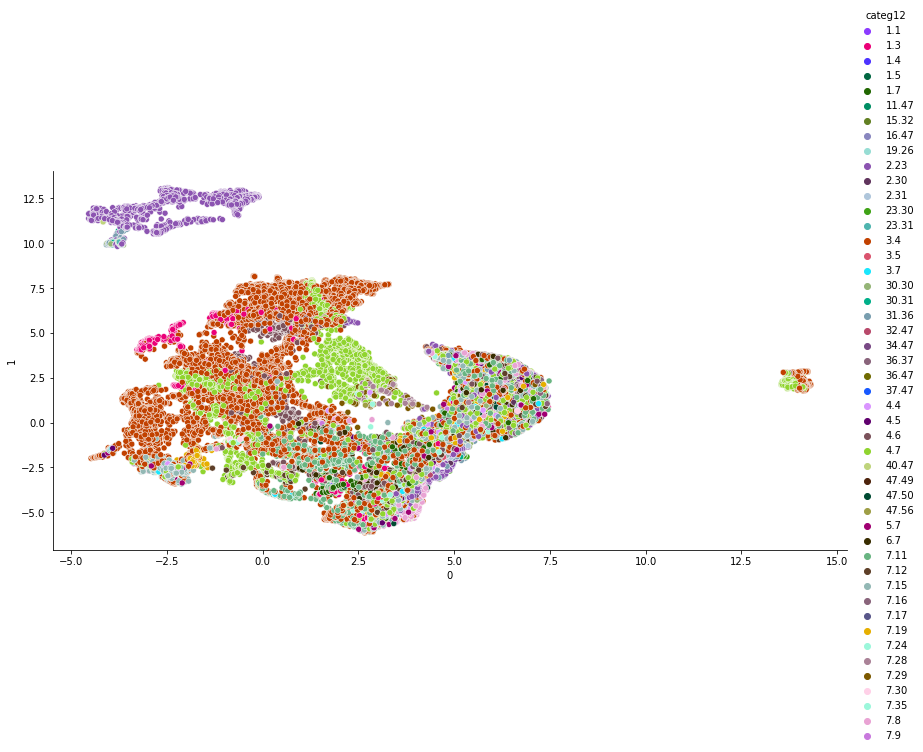

In [23]:
# choose our color palette
pal = seaborn.color_palette(cc.glasbey, n_colors=len(list(df_plot["categ12"])))

seaborn.relplot(data=df_plot, x=0, y=1, 
                hue='categ12', hue_order=sorted(list(df_plot["categ12"])), 
                palette=pal,
                aspect=2,
                height=6)
plt.show()

Plot the items grouped and colored by their first 3 categories:

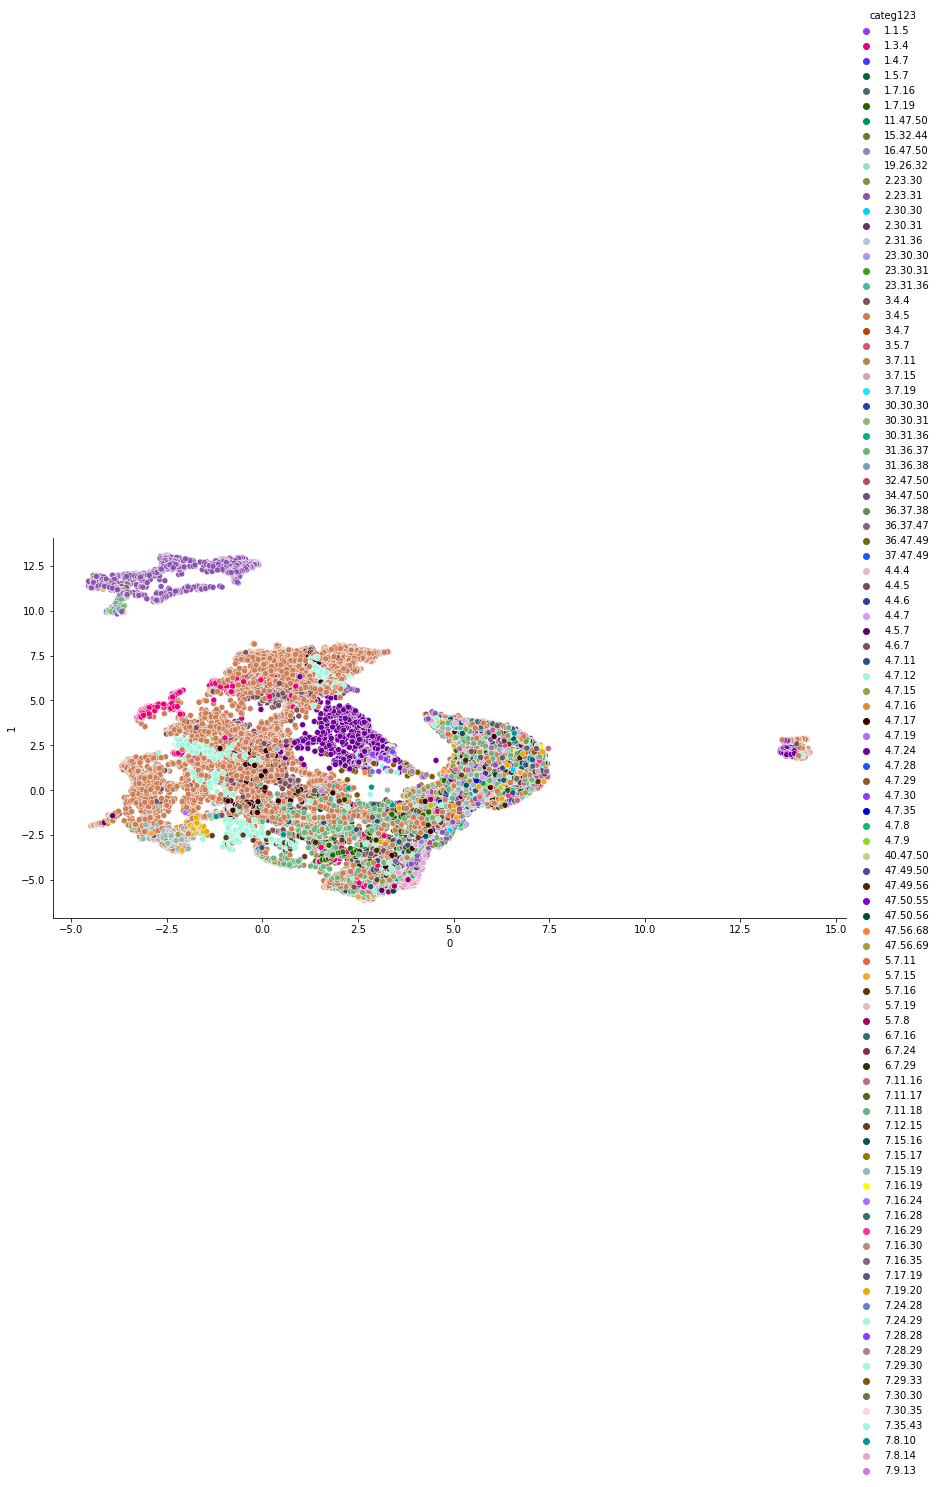

In [24]:
# choose our color palette
pal = seaborn.color_palette(cc.glasbey, n_colors=len(list(df_plot["categ123"])))

seaborn.relplot(data=df_plot, x=0, y=1, 
                hue='categ123', hue_order=sorted(list(df_plot["categ123"])), 
                palette=pal,
                aspect=2,
                height=6)
plt.show()

We can see that our model manages to categorize our items fairly well into the correct groups. 

Nevertheless, we do have quite some overlapping points, since it is likely that some items are categorized based on very broad categories making the grouping way less granular.

## 6 | Creating the Final Result File

Finally, we need to create the `results.csv` file as stated in the assignment on the TUWEL lecture page.

In [55]:
header = ['session_id', 'item_id', 'rank']

with open('results.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    
    for session in test_sessions_dict.keys():
        prediction = model.predict_output_word(context_words_list=test_sessions_dict[session], topn=100)
        if prediction != None:
            for rank, pred in enumerate(prediction):
                data = [session, pred[0], rank+1]
                # write the data
                writer.writerow(data)

In [2]:
#pip install --upgrade gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 40.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 KB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
#pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00 0:00:01m
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=b06f8df23ade16fa6639d5cac2b985b6a90691a06c75d7d711003f404326f7cb
  Stored in directory: /home/e01551237/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for pynndescent: filename=pynndescent-0.5.7-py3-none-any.whl size=54286 sha256=c401c85b14ca48eff2901a1e430124503aa8d97ace1d35756dd4e67159d223c3
  Stored in directory: /home/e01551237/.cache/pip/wheels/5b/f5/6e/aac11d69fe2115d9ac871d6c148b361f0d3f8a35ed7354fa03
Successfully built umap-learn pynndescent
Note: you may need to restart the kernel to use updated packages.


In [4]:
#pip install colorcet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
